In [203]:
%matplotlib notebook
import gym
import gym_watten
from gym_watten.envs.watten_env import Color, Value
import numpy as np
from time import sleep
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
env = gym.make("Watten-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Environment '<class 'gym_watten.envs.watten_env.WattenEnv'>' has deprecated methods. Compatibility code invoked.


In [179]:
EPISODES = 75
MCTS_SIMS = 100
MEMORY_SIZE = 30000

BATCH_SIZE = 256
TRAINING_LOOPS = 10

# Search

In [166]:
def search(obs):
    state = env.get_state()
    n = len(env.players[env.current_player].hand_cards)   
    p = 0
    current_player = env.current_player
    distr = np.zeros((n,))
    
    for i in range(n):
        card_id = env.players[env.current_player].hand_cards[i].id
        obs, rew, is_done, _ = env.step(card_id)
        
        if is_done:
            distr[i] = (rew[0] > 0)
        else:
            distr[i] = ((1 - search(obs)[0]) if current_player != env.current_player else search(obs)[0])
        env.set_state(state)
        p += distr[i]
        
    return distr.max(), distr

# MCTS

In [167]:
class State:
    def __init__(self, p, env_state, current_player=0, end_v=0):
        self.childs = []
        self.n = 0
        self.w = 0
        self.p = p
        self.env_state = env_state
        self.end_v = end_v
        self.current_player = current_player
        
    def is_leaf_node(self):
        return len(self.childs) == 0
    
    def size(self):
        size = 1
        for child in self.childs:
            size += child.size()
        return size
    
def mcts_sample(state, use_model=True):
    
    if state.is_leaf_node():
        if state.end_v != 0:
            v = state.end_v
        else:
            env.set_state(state.env_state)

            if use_model:
                p, v = model.predict_single(env.regenerate_obs())
            else:
                p, v = [1] *32, [0]
                
            hand_cards = env.players[env.current_player].hand_cards[:]        
            current_player = env.current_player
            for card in hand_cards:
                obs, rew, is_done, _ = env.step(card.id)

                new_state = State(p[card.id], env.get_state(), current_player, 0 if not is_done else (1 if rew[0] > 0 else -1))
                state.childs.append(new_state)

                env.set_state(state.env_state)

            v = v[0]  
    else:
        n_sum = 0
        for child in state.childs:
            n_sum += child.n
        
        max_u = 0
        max_child = None
        for child in state.childs:
            if child.end_v != 0:
                u = child.end_v
            elif child.n > 0:
                u = child.w / child.n 
            else:
                u = 0
            
            u += child.p * np.sqrt(n_sum) / (1 + child.n)

            if max_child is None or u > max_u:
                max_u, max_child = u, child

        v = mcts_sample(max_child) * (-1 if max_child.current_player != state.current_player else 1)
        
    state.w += v 
    state.n += 1
    return v

def mcts_game_step(root, steps=MCTS_SIMS, use_model=True):
    for i in range(steps):
        mcts_sample(root, use_model)
        
    p = [child.n for child in root.childs]
    p /= np.sum(p)
    return np.random.choice(np.arange(0, len(p)), p=p), p
    
def mcts_game():
    global sample_inputs, sample_outputs, next_index, number_of_samples
    obs = env.reset()
    root = State(1, env.get_state())
    is_done = False
    start_index = next_index
    indices = []
    
    while not is_done:
        indices.append(next_index)
        sample_inputs[0][next_index] = np.array(obs[0])
        sample_inputs[1][next_index] = np.array(obs[1])
        sample_outputs[1][next_index] = 1 if env.current_player is 0 else -1
        
        game_state = env.get_state()
        a, p = mcts_game_step(root)
        env.set_state(game_state)
        
        for i, card in enumerate(env.players[env.current_player].hand_cards):
            sample_outputs[0][next_index][card.id] = p[i]    
        
        next_index += 1
        next_index %= MEMORY_SIZE
        number_of_samples = max(number_of_samples, next_index)
        
        last_player = env.current_player
        obs, rew, is_done, _ = env.step(env.players[env.current_player].hand_cards[a].id)
        root = root.childs[a]
                
    for i in indices:
        sample_outputs[1][i][0] *= (1 if last_player is 0 else -1) * (1 if rew[0] > 0 else -1)
        
def mcts_generate():
    
    for i in tqdm(range(EPISODES)):
        mcts_game()
    #postprocess_samples()

def reset_samples():
    global sample_outputs, sample_inputs, next_index, number_of_samples
    sample_outputs = [np.zeros((MEMORY_SIZE, 32), dtype=float), np.zeros((MEMORY_SIZE, 1), dtype=int)]
    sample_inputs = [np.zeros((MEMORY_SIZE, 4, 8, 2), dtype=int), np.zeros((MEMORY_SIZE, 4), dtype=int)]
    next_index = 0
    number_of_samples = 0
    
def draw_tree(root):
    print("Root: " + str(root.end_v if root.n is 0 else root.w / root.n) + " / " + str(root.n))
    for child in root.childs:
        print( str(child.end_v if child.n is 0 else child.w / child.n) + " / " + str(child.n))

def draw_path(root):
    state = root
    while True:     
        print(str(state.current_player) + ": " + str(state.end_v if state.n is 0 else state.w / state.n) + " / " + str(state.n))
        
        if state.is_leaf_node():
            break
    
        max_u = 0
        max_child = None
        for child in state.childs:
            if child.end_v != 0:
                u = child.end_v
            elif child.n > 0:
                u = child.w / child.n 
            else:
                u = 0
                
            if max_child is None or u > max_u:
                max_u, max_child = u, child
        
        state = max_child


# Play

In [94]:
def match(agents, render=False):
    obs, is_done = env.reset(), False    
    
    while not is_done:
        if agents[env.current_player] is None:
            state = env.get_state()
            prediction = calc_correct_output(env.players[env.current_player].hand_cards, env.table_card, env.players[env.current_player].tricks, env.players[1 - env.current_player].tricks)
            env.set_state(state)
            #print("1", prediction, env.players[env.current_player].hand_cards[np.argmax(prediction)].color.name, env.players[env.current_player].hand_cards[np.argmax(prediction)].value.name)
            a = env.players[env.current_player].hand_cards[np.argmax(prediction)].id
            #break
        else:
            prediction = agents[env.current_player].predict_single(obs)[0]
           # print("2", prediction)
        
            valid_moves = np.array([1 if card in env.players[env.current_player].hand_cards else 0 for card in env.cards])       

            prediction_valid = np.ma.masked_where(valid_moves == 0, prediction)
            a = np.argmax(prediction_valid)
                    
        obs, rew, is_done, _ = env.step(a)
        
        if render:
            env.render('human')
            sleep(1)
        
    return env.current_player

def compare(agent1, agent2):
    agents = [agent1, agent2]
    first_player_wins = 0
    
    for i in range(10):
        start_player = random.randint(0, 1)
        winner = match([agents[start_player], agents[1 - start_player]])
        first_player_wins += ((winner == 0) == (start_player == 0))
        print(i, first_player_wins)
    
    return first_player_wins / 10    

In [139]:
compare(random_model, None)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 1
8 1
9 1


0.1

# Model

In [7]:
from keras.models import Sequential, clone_model
from keras.layers import Dense, Activation, Input, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, Merge, Flatten, BatchNormalization, add
from keras.layers.merge import concatenate
from keras.models import Model

import keras.backend as K
from IPython.display import clear_output
from keras import optimizers
import math

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [232]:
class ImprovedModel(Model):
    def __init__(self, inputs, outputs):
        super().__init__(inputs, outputs)

    def predict_single(self, inputs):
        inputs = [np.expand_dims(input, 0) for input in inputs]
        outputs = self.predict(inputs)
        return [output[0] for output in outputs]

def mean_pred(y_true, y_pred):
    return K.mean(K.equal(K.gather(y_true, K.argmax(y_true, axis=-1)), K.gather(y_true, K.argmax(y_pred, axis=-1))))


def residual_layer(input_block, filters, kernel_size):

    x = conv_layer(input_block, filters, kernel_size)

    x = Conv2D(
    filters = filters
    , kernel_size = kernel_size
    , padding = 'same'
    , use_bias=False
    , activation='linear'
    )(x)

    #x = BatchNormalization(axis=1)(x)

    x = add([input_block, x])

    x = LeakyReLU()(x)

    return (x)

def conv_layer(x, filters, kernel_size):

    x = Conv2D(
    filters = filters
    , kernel_size = kernel_size
    , padding = 'same'
    , use_bias=False
    , activation='linear'
    )(x)

    #x = BatchNormalization(axis=1)(x)
    x = LeakyReLU()(x)

    return (x)

def build_model():
    
    input_1 = Input((4,8,2))
    convnet = input_1

    convnet = conv_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    #convnet = conv_layer(convnet, 2, (1, 1))
    #convnet = Conv2D(32, (3, 3), activation='relu', padding='same')(convnet)
    #convnet = Conv2D(64, (3, 3), activation='relu', padding='same')(convnet)
    #convnet = Conv2D(64, (3, 3), activation='relu', padding='same')(convnet)
    #convnet = Conv2D(64, (3, 3), activation='relu', padding='same')(convnet)
    convnet = Flatten()(convnet)

    input_2 = Input((4,))

    policy_out = concatenate([convnet, input_2])
    #dense_out = Dense(128, activation='relu')(dense_out)
    #dense_out = Dense(256, activation='relu')(dense_out)
    #policy_out = Dense(256, activation='relu')(dense_out)
    policy_out = Dense(32, activation='sigmoid')(policy_out)

    value_out = concatenate([convnet, input_2])
    #dense_out = Dense(128, activation='relu')(dense_out)
    #dense_out = Dense(256, activation='relu')(dense_out)
    value_out = Dense(256, activation='relu')(value_out)
    value_out = Dense(1, activation='tanh')(value_out)

    model = ImprovedModel(inputs=[input_1, input_2], outputs=[policy_out, value_out])

    adam = optimizers.Adam()
    model.compile(optimizer=adam,
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

# Train

<IPython.core.display.Javascript object>


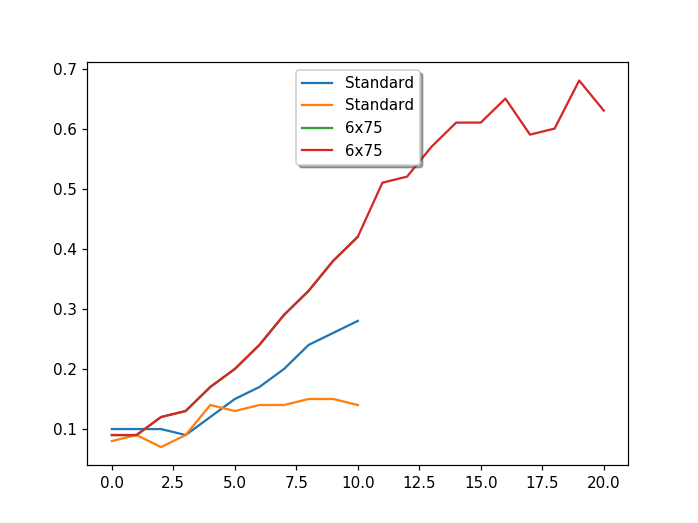

In [220]:
fig, ax = plt.subplots()

In [234]:
model = build_model()
trained_model = build_model()
trained_model.set_weights(model.get_weights())
#model.summary()

In [235]:
reset_samples()
eval_scores = [eval(trained_model, eval_cache_input, eval_cache_output)]
all_eval_scores = eval_scores[:]


In [238]:
for i in range(10):  
    mcts_generate()
    clear_output()
    
    p = np.random.permutation(int(number_of_samples))
    if len(p) > BATCH_SIZE * TRAINING_LOOPS:
        p = p[:BATCH_SIZE * TRAINING_LOOPS]
    train_outputs = []
    train_inputs = []
    for i in range(len(sample_outputs)):
        train_outputs.append(sample_outputs[i][p])
    for i in range(len(sample_inputs)):
        train_inputs.append(sample_inputs[i][p])
        
    trained_model.fit(train_inputs, train_outputs, epochs=1, batch_size=BATCH_SIZE)    
    
    eval_new = eval(trained_model, eval_cache_input, eval_cache_output)
    if eval_new > eval_scores[-1]:
        eval_scores.append(eval_new)
        print("New model score: " + str(eval_scores[-1]) + "!")
        model.set_weights(trained_model.get_weights())
    print("Last scores: " + str(eval_scores[::-1]) + "!")
    all_eval_scores.append(eval_new)
    
plt.plot(all_eval_scores, label='6x75')
ax.legend(loc='upper center', shadow=True)
plt.show()

Epoch 1/1
2560/2560 [==============================] - 6s 2ms/step - loss: 0.6009 - dense_85_loss: 0.0172 - dense_87_loss: 0.5836 - dense_85_acc: 0.4203 - dense_87_acc: 0.5363


  0%|          | 0/75 [00:00<?, ?it/s]

Last scores: [0.68, 0.65, 0.61, 0.57, 0.52, 0.51, 0.42, 0.38, 0.33, 0.29, 0.24, 0.2, 0.17, 0.13, 0.12, 0.09]!


 11%|█         | 8/75 [00:03<00:26,  2.53it/s]


KeyboardInterrupt: 

In [197]:
number_of_samples

29999

In [ ]:
model.save('model.h5')

In [ ]:
model.load_weights('model.h5')

# Eval

In [ ]:
generate_training_data(100)    
p = np.random.permutation(len(sample_inputs))
sample_inputs, sample_outputs = sample_inputs[p], sample_outputs[p]

In [ ]:
model.evaluate(sample_inputs, sample_outputs)

# Predict

In [13]:
def generate_input(hand_cards, table_card=None, own_tricks=0, opponent_tricks=0):
    obs = [np.zeros([4, 8, 2]), np.zeros([4])]
    
    for card in hand_cards:
        obs[0][card.color.value][card.value.value][0] = 1
        
    if table_card is not None:
        obs[0][table_card.color.value][table_card.value.value][1] = 1

    obs[1][0] = (own_tricks == 1 or own_tricks == 3)
    obs[1][1] = (own_tricks == 2 or own_tricks == 3)

    obs[1][2] = (opponent_tricks == 1 or opponent_tricks == 3)
    obs[1][3] = (opponent_tricks == 2 or opponent_tricks == 3)
    
    return obs

In [14]:
def card(color, value):
    for card in env.cards:
        if card.value == value and card.color == color:
            return card
        
    return None

In [113]:
def calc_correct_output_sample(hand_cards, table_card=None, own_tricks=0, opponent_tricks=0):
    global sample_outputs
    env.reset()
    env.cards_left = env.cards[:]
    random.shuffle(env.cards_left)
    
    for card in hand_cards:
        env.cards_left.remove(card)
    env.players[0].hand_cards = hand_cards[:]
        
    env.players[1].hand_cards = []
    for i in range(len(hand_cards) - (1 if table_card is not None else 0)):
        env.players[1].hand_cards.append(env.cards_left.pop())       
    
    env.players[0].tricks = own_tricks
    env.players[1].tricks = opponent_tricks
    env.table_card = table_card
    
    #obs, rew, is_done, _ = env.step(hand_cards[0].id)
   # print(rew, is_done)

    #env.render('human')
    #root = State(1, env.get_state())
    #a, p = mcts_game_step(root, 1000, False)
    #draw_tree(root)
    #print("")
    #draw_tree(root.childs[0])
    
    #draw_path(root)
    #reset_samples(1)
    p = search(env.regenerate_obs())[1]
    #postprocess_samples()
        
    return p#sample_outputs[0]

In [100]:
def calc_correct_output(hand_cards, table_card=None, own_tricks=0, opponent_tricks=0):    
    correct_output = None
    for i in range(100):
        sample_outputs = calc_correct_output_sample(hand_cards, table_card, own_tricks, opponent_tricks)
        if correct_output is None:
            correct_output = sample_outputs
        else:
            correct_output += sample_outputs
    return correct_output / 100

In [110]:
def predict(hand_cards, table_card=None, own_tricks=0, opponent_tricks=0):
    input = generate_input(hand_cards, table_card, own_tricks, opponent_tricks)
    output = model.predict_single(input)[0]
    correct_output = calc_correct_output_sample(hand_cards, table_card, own_tricks, opponent_tricks)
    print(output,correct_output)
    id = 0
    for card in hand_cards:
        print(str(card.color) + " " + str(card.value) + " => " + str(output[card.id]) + " (" + str(correct_output[id]) + ")")
        id += 1

In [185]:
def create_eval_cache():
    eval_cache_input = []
    eval_cache_output = []
    for i in range(100):
        own_tricks = random.randint(0, 2)
        opponent_tricks = random.randint(0, 2)
        table_card_enabled = random.randint(0, 1)
        hand_cards = random.sample(env.cards, 5 - own_tricks - opponent_tricks + table_card_enabled)
        table_card = hand_cards.pop() if table_card_enabled else None

        eval_cache_input.append(generate_input(hand_cards, table_card, own_tricks, opponent_tricks))
        output = calc_correct_output(hand_cards, table_card, own_tricks, opponent_tricks)
        
        outputs_per_card = np.zeros((32,))
        for i in range(len(hand_cards)):
            outputs_per_card[hand_cards[i].id] = output[i]
            
        eval_cache_output.append(outputs_per_card)
        
    return eval_cache_input, eval_cache_output
        
def eval(model, eval_cache_input, eval_cache_output):
    correct = 0
    for i in range(len(eval_cache_input)):

        output = model.predict_single(eval_cache_input[i])[0]
        correct_output = eval_cache_output[i]
                    
        correct += correct_output[np.argmax(output)] == correct_output[np.argmax(correct_output)]
        #if correct_output[np.argmax(output)] != correct_output[np.argmax(correct_output)]:
        #    print(correct_output[np.argmax(output)], correct_output[np.argmax(correct_output)])
            
    return correct / len(eval_cache_input)


In [164]:
eval_cache_input, eval_cache_output = create_eval_cache()

In [161]:
eval(eval_cache_input, eval_cache_output)


0.29 0.29


1.0

In [127]:
predict([
    card(Color.EICHEL, Value.ACHT), 
    card(Color.EICHEL, Value.KOENIG),
    card(Color.HERZ, Value.SAU)
    ], None, 0, 2)


[1.3552429e-03 4.5358184e-01 4.6454603e-03 6.4368802e-04 4.6525458e-03
 3.9433949e-03 1.5112920e-01 3.0173792e-04 1.2520696e-03 1.0854086e-03
 1.7174638e-03 1.7721410e-04 1.8285712e-02 2.9316519e-03 6.9040695e-04
 1.1141861e-03 4.1364837e-01 4.2039421e-04 2.3993296e-03 5.7367404e-04
 6.7652315e-03 2.2710238e-03 3.9055911e-03 2.6075791e-03 1.8998339e-03
 1.4971480e-03 2.8953989e-04 2.9743905e-03 1.0059150e-03 8.4979401e-04
 6.7597942e-04 4.0198429e-03] [0, 0, 0]
Color.EICHEL Value.ACHT => 0.1511292 (0)
Color.EICHEL Value.KOENIG => 0.45358184 (0)
Color.HERZ Value.SAU => 0.41364837 (0)


In [137]:
calc_correct_output([
    card(Color.EICHEL, Value.SAU), 
    card(Color.GRUEN, Value.UNTER),
    card(Color.HERZ, Value.SAU)
    ],card(Color.EICHEL, Value.ZEHN), 0, 2)

array([0.42, 0.  , 0.42])